# Assignment09
# Multi-label classification using neural networks
* 2019220177 Seungwook

## Initial Setting

### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/My\ Drive/MIMP

/content/drive/My Drive/MIMP


### git Setting

In [16]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   Assignment09/Assignment09.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [0]:
!git config --global user.email "sooonchang@gmail.com"
!git config --global user.name "SooonChang"

In [18]:
!git add .
!git commit -m "Assignment09: 2,3 Plot the results"
!git push origin master

[master 3429a76] Assignment09: 2,3 Plot the results
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Assignment09/Assignment09.ipynb (94%)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 30.72 KiB | 3.07 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/SooonChang/MIMP
   edb99b2..3429a76  master -> master


## 0. Optimization

### Import Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

### Load Data


In [0]:
file_data = "Assignment09/mnist.csv"
handle_file = open(file_data, "r")
data = handle_file.readlines()
handle_file.close()

size_row = 28
size_col = 28

num_image = len(data)
count = 0

list_image = np.empty((num_image,size_row* size_col), dtype=float)
list_label = np.empty(num_image, dtype = int)

for line in data:
  line_data = line.split(',')
  label = line_data[0]
  im_vector = np.asfarray(line_data[1:])

  list_label[count] = label
  list_image[count,:] = im_vector
  count +=1


### define module

In [0]:
def sigmoid(x):
  return 1/ (1 + np.exp(-x))

class Sigmoid():
  
  def __init__(self):
    self.out = None
  
  def forward(self, x):
    out = sigmoid(x)
    self.out = out
    return out
  
  def backward(self, dout): # s' = (1-s)*s
    dx = dout*(1.0 - self.out) * self.out

    return dx

class Layer():
  def __init__(self,W,b):
    self.W = W
    self.b = b

    self.x = None
    self.x_shape = None
    # differntial
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x_shape = x.shape
    x = x.reshape(x.shape[0],-1)
    self.x = x

    out = np.dot(self.x,self.W) + self.b

    return out
  
  def backward(self,dout):
    dx = np.dot(dout,self.W.T)
    self.dW = np.dot(self.x.T,dout)
    self.db = np.sum(dout, axis=0)

    dx = dx.reshape(*self.x_shape)
    return dx

class object_func():
  def __init__(self):
    self.loss = None
    self.h = None
    self.t = None

  def forward(self, y, t):
    self.t = t
    self.h = sigmoid(y)
    m = t.shape[0]
    self.loss = np.sum(-t*np.log(self.h +1e-7) -(1-t)*np.log(1-self.h +1e-7)) / m

    return self.loss
  
  def backward(self, dout=1):
    m = self.t.shape[0]
    dx = (self.h - self.t)/m
    
    return dx


In [0]:
class Network():

  def __init__(self, std = 0.01):
    # init weights
    self.params = {}
    self.params['W1'] = std*np.random.randn(784,196)
    self.params['b1'] = np.zeros(196)
    self.params['W2'] = std*np.random.randn(196,49)
    self.params['b2'] = np.zeros(49)
    self.params['W3'] = std*np.random.randn(49,10)
    self.params['b3'] = np.zeros(10)

    # create layers
    self.layers = OrderedDict()
    self.layers['Layer1'] = Layer(self.params['W1'], self.params['b1'])
    self.layers['Sigmoid1'] = Sigmoid()
    self.layers['Layer2'] = Layer(self.params['W2'], self.params['b2'])
    self.layers['Sigmod2'] = Sigmoid()
    self.layers['Layer3'] = Layer(self.params['W3'], self.params['b3'])

    self.lastLayer = object_func()
  
  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)
    
    return x
  
  def loss(self, x, t):
    y = self.predict(x)
    return self.lastLayer.forward(y,t)
  
  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)

    accuracy = np.sum(y==t)/ float(x.shape[0])
    return accuracy

  def gradient(self, x, t):
    # forward
    self.loss(x,t)

    # backward
    dout =1
    dout = self.lastLayer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)
    
    # save gradients
    grads = {}
    grads['W1'],grads['b1'] = self.layers['Layer1'].dW, self.layers['Layer1'].db
    grads['W2'],grads['b2'] = self.layers['Layer2'].dW,self.layers['Layer2'].db
    grads['W3'],grads['b3'] = self.layers['Layer3'].dW,self.layers['Layer3'].db

    return grads

In [0]:
## Separate dataset to train & test

train_img = list_image[:6000,:]
train_lab = list_label[:6000]
test_img = list_image[6000:,:]
test_lab = list_label[6000:]

In [0]:
## make label -> one-hot-encoding
num_train = len(train_lab)
train_enc = np.empty((num_train,10),dtype=int)
for i in range(num_train):
  for j in range(10):
    train_enc[i][j] = int(j==train_lab[i])

num_test = len(test_lab)
test_enc = np.empty((num_test,10),dtype=int)
for i in range(num_test):
  for j in range(10):
    test_enc[i][j] = int(j==test_lab[i])

In [0]:
network = Network()

num_iteration = 10000
lr = 0.1
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

In [12]:
### Training ###

for i in range(num_iteration):
  grad = network.gradient(train_img, train_enc)

  for key in ('W1','b1', 'W2', 'b2', 'W3', 'b3'):
    network.params[key] -= lr*grad[key]
  
  train_loss = network.loss(train_img,train_enc)
  train_loss_list.append(train_loss)
  test_loss = network.loss(test_img,test_enc)
  test_loss_list.append(test_loss)

  train_acc = network.accuracy(train_img, train_enc)
  test_acc = network.accuracy(test_img,test_enc)
  train_acc_list.append(train_acc)
  test_acc_list.append(test_acc)

  if i%100 == 0:
    print("Epoch : ", i)
    print("train_loss: ",train_loss, "train_acc", train_acc)
    print("test_loss:", test_loss, "test_acc", test_acc)

Epoch :  0
train_loss:  5.136715399871972 train_acc 0.11433333333333333
test_loss: 5.137527204994452 test_acc 0.11225
Epoch :  100
train_loss:  3.2454569719094404 train_acc 0.11433333333333333
test_loss: 3.2467913426163397 test_acc 0.11225
Epoch :  200
train_loss:  3.2037247895159173 train_acc 0.1315
test_loss: 3.2076900347681514 test_acc 0.122
Epoch :  300
train_loss:  2.6667825502430973 train_acc 0.4196666666666667
test_loss: 2.687092189733985 test_acc 0.41675
Epoch :  400
train_loss:  2.1874789027219066 train_acc 0.5276666666666666
test_loss: 2.247143842746196 test_acc 0.50675
Epoch :  500
train_loss:  1.9087400029972763 train_acc 0.6416666666666667
test_loss: 1.9807580264767894 test_acc 0.6305
Epoch :  600
train_loss:  1.6911974413642283 train_acc 0.769
test_loss: 1.775570836762523 test_acc 0.7505
Epoch :  700
train_loss:  1.4615994341295226 train_acc 0.8158333333333333
test_loss: 1.5342267072458626 test_acc 0.8185
Epoch :  800
train_loss:  1.1795048215445025 train_acc 0.8801666666

## 2. Plot the loss curve

In [0]:
iteration = np.arange(0, num_iteration)

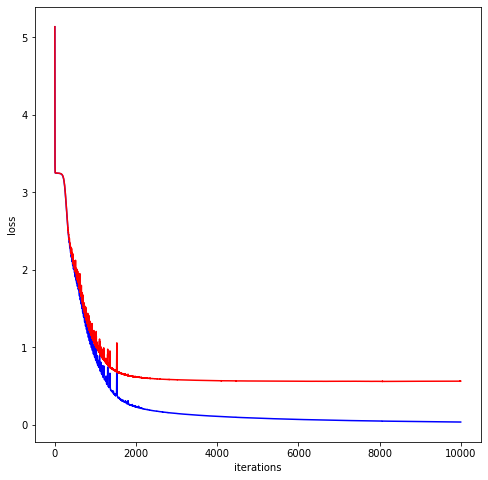

In [14]:
plt.figure(figsize=(8,8))
plt.xlabel("iterations")
plt.ylabel("loss")
plt.plot(iteration, train_loss_list, c='b')
plt.plot(iteration, test_loss_list, c='r')
plt.show()

## 3. Plot the accuracy value

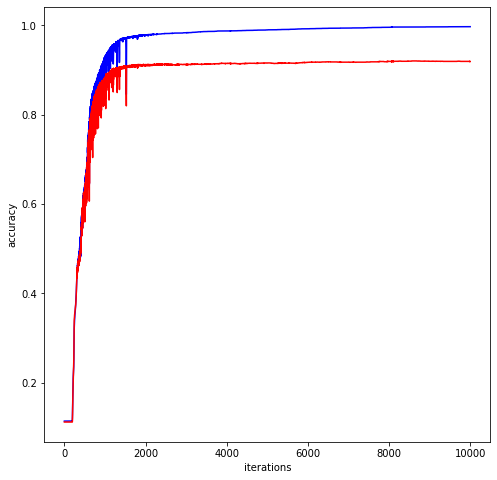

In [15]:
plt.figure(figsize=(8,8))
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.plot(iteration, train_acc_list, c='b')
plt.plot(iteration, test_acc_list, c='r')
plt.show()

In [19]:
print("Final Train Accuracy : ", train_acc_list[-1])
print("Final Test Accuracy : ", test_acc_list[-1])

Final Train Accuracy :  0.9971666666666666
Final Test Accuracy :  0.91925


## 4. Plot the classification example

In [0]:
corec_img = []
corec_lab = []
mis_img = []
mis_lab = []

In [0]:
pred = network.predict(test_img)
pred = np.argmax(pred,axis=1) ## predicted label
lab = np.argmax(test_enc,axis=1) ## correct label

for i in range(len(test_lab)):
  if pred[i] == lab[i]:
    corec_img.append(test_img[i])
    corec_lab.append(pred[i])
  else:
    mis_img.append(test_img[i])
    mis_lab.append(pred[i])

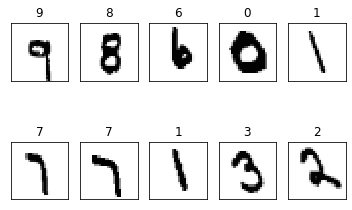

In [55]:
f1 = plt.figure(1)
for i in range(10):
  label = corec_lab[i]
  im_vector = corec_img[i]

  plt.subplot(2,5,i+1)
  plt.title(label)
  plt.imshow(im_vector.reshape(size_row,size_col), cmap='Greys',
             interpolation='None')
  frame = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)
plt.show()

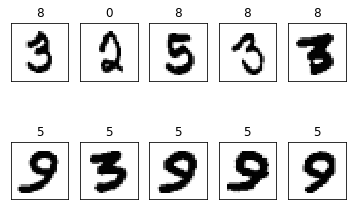

In [56]:
f2 = plt.figure(1)
for i in range(10):
  label = mis_lab[i+2]
  im_vector = mis_img[i+2]

  plt.subplot(2,5,i+1)
  plt.title(label)
  plt.imshow(im_vector.reshape(size_row,size_col), cmap='Greys',
             interpolation='None')
  frame = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)
plt.show()